## Ce code prédit les variables taux_occupation et temps de parcours avec un LSTM (prédiction de serie temporelle) avec variables explicatives :
## 'taux_occupation', 'temps_de_parcours', 'temperature_2m', 'precipitation', 'visibility','wind_speed_10m','has_event_near_troncon', 'weekday', 'is_vacances', 'is_ferie'

# Import librairies

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from joblib import load 
from joblib import dump

# Import dataset

In [2]:
link = '/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet'

In [3]:
df_trafic = pd.read_parquet(link)

In [5]:
df_trafic.columns

Index(['nom_du_troncon', 'heure_arrondie', 'id_technique', 'id', 'debit',
       'longueur', 'taux_occupation', 'code_couleur', 'etat_du_trafic',
       'temps_de_parcours', 'vitesse', 'geo_point_2d', 'geometrie',
       'shape_geo', 'horodatage', 'type_geo', 'coordinates_geo',
       'horodatage_date', 'jour', 'is_vacances', 'is_ferie',
       'rounded_horodatage', 'date', 'temperature_2m', 'visibility',
       'precipitation', 'wind_speed_10m', 'gml_id', 'date_ech', 'code_qual',
       'lib_qual', 'coul_qual', 'date_dif', 'source', 'type_zone', 'code_zone',
       'lib_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10', 'code_pm25',
       'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg', 'etat_indice',
       'geom_type', 'geom_coordinates', 'geo_point_2d_lon', 'geo_point_2d_lat',
       'has_event_near_troncon', 'weekday', 'hour', 'minute', 'troncon_enc'],
      dtype='object')

In [11]:
# --- Vérifie que CUDA est dispo ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# --- Chargement et tri du DataFrame ---
df = df_trafic.copy()
df['date_time'] = pd.to_datetime(df['heure_arrondie'])
df.sort_values(by=['nom_du_troncon', 'date_time'], inplace=True)

In [7]:
n_troncons = df['troncon_enc'].nunique()

In [8]:
# --- Split Train / Test ---
train_df = df[df['date_time'] < '2025-03-08']
test_df = df[df['date_time'] >= '2025-03-08']

In [9]:
# --- Features numériques à normaliser ---
features = ['taux_occupation', 'temps_de_parcours', 'temperature_2m', 'precipitation', 'visibility','wind_speed_10m',
            'has_event_near_troncon', 'weekday', 'is_vacances', 'is_ferie']
scaler = StandardScaler()
scaler.fit(train_df[features])

StandardScaler()

In [10]:
# SAUVEGARDER le scaler maintenant qu'il est entraîné
dump(scaler, 'mon_scaler.joblib')
print("Scaler sauvegardé.")


# appliquer la transformation aux deux jeux de données
print("Application de la transformation...")
train_df[features] = scaler.transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

Scaler sauvegardé.
Application de la transformation...


<ipython-input-10-c6270df6d7fa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features] = scaler.transform(train_df[features])
<ipython-input-10-c6270df6d7fa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[features] = scaler.transform(test_df[features])


In [12]:
# --- Ajoute l'encodage du tronçon à chaque ligne comme feature supplémentaire ---
df['troncon_feature'] = df['troncon_enc']

In [13]:
# --- Création des séquences avec tronçon ---
SEQ_LEN = 96

In [14]:
def create_sequences(data, seq_len):
    xs, ys, tr_ids = [], [], []
    grouped = data.groupby('troncon_enc')
    
    for troncon_id, group in grouped:
        group = group.sort_values('heure_arrondie')
        feats = group[features].values
        for i in range(len(feats) - seq_len):
            x = feats[i:i+seq_len]
            y = feats[i+seq_len, :2]  # [taux_occupation, temps_de_parcours]
            xs.append(x)
            ys.append(y)
            tr_ids.append(troncon_id)  # tronçon associé à cette séquence

    return np.array(xs), np.array(ys), np.array(tr_ids)

X_train, y_train, tr_train = create_sequences(train_df, SEQ_LEN)
X_test, y_test, tr_test = create_sequences(test_df, SEQ_LEN)

In [15]:
# --- Dataset PyTorch ---
class TrafficDataset(Dataset):
    def __init__(self, X, y, troncon_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.troncon_ids = torch.tensor(troncon_ids, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.troncon_ids[idx], self.y[idx]

train_dataset = TrafficDataset(X_train, y_train, tr_train)
test_dataset = TrafficDataset(X_test, y_test, tr_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
# --- Modèle LSTM avec Embedding tronçon ---
class LSTMWithTronconEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim=64, output_dim=2, num_layers=2, n_troncons=1):
        super().__init__()
        self.embedding = nn.Embedding(n_troncons, embedding_dim)
        self.lstm = nn.LSTM(input_dim + embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, troncon_id):
        # x shape: (batch, seq_len, input_dim)
        emb = self.embedding(troncon_id)  # (batch, embedding_dim)
        emb_seq = emb.unsqueeze(1).expand(-1, x.size(1), -1)  # (batch, seq_len, embedding_dim)
        x_cat = torch.cat([x, emb_seq], dim=2)  # (batch, seq_len, input_dim + embedding_dim)
        out, _ = self.lstm(x_cat)
        out = out[:, -1, :]  # prend le dernier pas de temps
        out = self.fc(out)
        return out

In [17]:
# --- Initialisation ---
model = LSTMWithTronconEmbedding(
    input_dim=len(features),
    embedding_dim=8,
    hidden_dim=64,
    output_dim=2,
    num_layers=2,
    n_troncons=n_troncons
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# --- Entraînement ---
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, tr_ids, y_batch in train_loader:
        X_batch = X_batch.to(device)
        tr_ids = tr_ids.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch, tr_ids)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/20 - Loss: 0.5218
Epoch 2/20 - Loss: 0.4974
Epoch 3/20 - Loss: 0.4893
Epoch 4/20 - Loss: 0.4810
Epoch 5/20 - Loss: 0.4765
Epoch 6/20 - Loss: 0.4685
Epoch 7/20 - Loss: 0.4647
Epoch 8/20 - Loss: 0.4556
Epoch 9/20 - Loss: 0.4434
Epoch 10/20 - Loss: 0.4452
Epoch 11/20 - Loss: 0.4377
Epoch 12/20 - Loss: 0.4332
Epoch 13/20 - Loss: 0.4301
Epoch 14/20 - Loss: 0.4287
Epoch 15/20 - Loss: 0.4187
Epoch 16/20 - Loss: 0.4237
Epoch 17/20 - Loss: 0.4165
Epoch 18/20 - Loss: 0.4116
Epoch 19/20 - Loss: 0.4180
Epoch 20/20 - Loss: 0.4044


In [19]:
# # --- Évaluation ---
# model.eval()
# all_preds, all_targets, all_tr_enc = [], [], []

# with torch.no_grad():
#     for X_batch, tr_ids, y_batch in test_loader:
#         X_batch = X_batch.to(device)
#         tr_ids = tr_ids.to(device)
#         preds = model(X_batch, tr_ids).cpu().numpy()
        
#         all_preds.append(preds)
#         all_targets.append(y_batch.numpy())
#         all_tr_enc.append(tr_ids.cpu().numpy())

# y_pred = np.concatenate(all_preds)
# y_true = np.concatenate(all_targets)
# tr_enc = np.concatenate(all_tr_enc)

# # Calcul du MSE
# mse = np.mean((y_true - y_pred)**2, axis=0)
# print(f"\nTest MSE - taux_occupation: {mse[0]:.4f}, temps_de_parcours: {mse[1]:.4f}")

# # --- Création des colonnes heure_arrondie et nom_du_troncon correspondantes ---

# def get_seq_start_times(data, seq_len):
#     times = []
#     grouped = data.groupby('troncon_enc')
#     for troncon_id, group in grouped:
#         group = group.sort_values('heure_arrondie').reset_index(drop=True)
#         for i in range(len(group) - seq_len):
#             times.append(group.loc[i, 'heure_arrondie'])
#     return times

# def get_seq_troncon_names(data, seq_len):
#     noms = []
#     grouped = data.groupby('troncon_enc')
#     for troncon_id, group in grouped:
#         group = group.sort_values('heure_arrondie').reset_index(drop=True)
#         for i in range(len(group) - seq_len):
#             noms.append(group.loc[i, 'nom_du_troncon'])
#     return noms

# heure_arrondie_seq = get_seq_start_times(test_df, SEQ_LEN)
# nom_du_troncon_seq = get_seq_troncon_names(test_df, SEQ_LEN)

# # --- Création des DataFrames pour CSV ---

# df_taux = pd.DataFrame({
#     'heure_arrondie': heure_arrondie_seq,
#     'nom_du_troncon': nom_du_troncon_seq,
#     'taux_occupation_reel': y_true[:, 0],
#     'taux_occupation_pred': y_pred[:, 0]
# })

# df_temps = pd.DataFrame({
#     'heure_arrondie': heure_arrondie_seq,
#     'nom_du_troncon': nom_du_troncon_seq,
#     'temps_de_parcours_reel': y_true[:, 1],
#     'temps_de_parcours_pred': y_pred[:, 1]
# })

# df_taux.to_csv('taux_occupation_predictions.csv', index=False)
# df_temps.to_csv('temps_de_parcours_predictions.csv', index=False)

# print("Fichiers CSV sauvegardés.")

In [20]:

# --- Évaluation ---
model.eval()
all_preds, all_targets, all_tr_enc = [], [], []

with torch.no_grad():
    for X_batch, tr_ids, y_batch in test_loader:
        X_batch = X_batch.to(device)
        tr_ids = tr_ids.to(device)
        preds = model(X_batch, tr_ids).cpu().numpy()
        
        all_preds.append(preds)
        all_targets.append(y_batch.numpy())
        all_tr_enc.append(tr_ids.cpu().numpy())

# Renommage pour plus de clarté : ce sont les données normalisées
y_pred_normalized = np.concatenate(all_preds)
y_true_normalized = np.concatenate(all_targets)
tr_enc = np.concatenate(all_tr_enc)

# Le calcul du MSE sur les données normalisées est une bonne pratique pour évaluer le modèle
mse = np.mean((y_true_normalized - y_pred_normalized)**2, axis=0)
print(f"\nTest MSE (sur données normalisées) - taux_occupation: {mse[0]:.4f}, temps_de_parcours: {mse[1]:.4f}")


# --- DÉ-STANDARDISATION AVANT DE CRÉER LES CSV ---
print("\nDé-standardisation des prédictions pour la sauvegarde...")

# 1. Chargez votre scaler qui a été "fitté" sur les données d'entraînement
scaler = load('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/src/mon_scaler.joblib') 

# 2. Définissez l'ordre exact et le nombre de colonnes que votre scaler a appris
num_features = len(features)

# 3. Créez des tableaux "factices" avec la bonne forme pour la transformation inverse
dummy_pred_array = np.zeros((len(y_pred_normalized), num_features))
dummy_true_array = np.zeros((len(y_true_normalized), num_features))

# 4. Remplissez les colonnes que nous avons prédites (les 2 premières)
dummy_pred_array[:, :2] = y_pred_normalized
dummy_true_array[:, :2] = y_true_normalized

# 5. Appliquez la transformation inverse
y_pred_rescaled = scaler.inverse_transform(dummy_pred_array)
y_true_rescaled = scaler.inverse_transform(dummy_true_array)
# --- FIN DE LA DÉ-STANDARDISATION ---


# --- Création des colonnes heure_arrondie et nom_du_troncon correspondantes ---

def get_seq_start_times(data, seq_len):
    times = []
    grouped = data.groupby('troncon_enc')
    for troncon_id, group in grouped:
        group = group.sort_values('heure_arrondie').reset_index(drop=True)
        for i in range(len(group) - seq_len):
            times.append(group.loc[i, 'heure_arrondie'])
    return times

def get_seq_troncon_names(data, seq_len):
    noms = []
    grouped = data.groupby('troncon_enc')
    for troncon_id, group in grouped:
        group = group.sort_values('heure_arrondie').reset_index(drop=True)
        for i in range(len(group) - seq_len):
            noms.append(group.loc[i, 'nom_du_troncon'])
    return noms

heure_arrondie_seq = get_seq_start_times(test_df, SEQ_LEN)
nom_du_troncon_seq = get_seq_troncon_names(test_df, SEQ_LEN)


# --- Création des DataFrames pour CSV avec les données à l'échelle réelle ---

df_taux = pd.DataFrame({
    'heure_arrondie': heure_arrondie_seq,
    'nom_du_troncon': nom_du_troncon_seq,
    # On utilise les colonnes dé-standardisées
    'taux_occupation_reel': y_true_rescaled[:, 0], 
    'taux_occupation_pred': y_pred_rescaled[:, 0]
})

df_temps = pd.DataFrame({
    'heure_arrondie': heure_arrondie_seq,
    'nom_du_troncon': nom_du_troncon_seq,
    # On utilise les colonnes dé-standardisées
    'temps_de_parcours_reel': y_true_rescaled[:, 1],
    'temps_de_parcours_pred': y_pred_rescaled[:, 1]
})

df_taux.to_csv('taux_occupation_predictions.csv', index=False)
df_temps.to_csv('temps_de_parcours_predictions.csv', index=False)

print("\nFichiers CSV avec des valeurs à l'échelle réelle ont été sauvegardés.")


Test MSE (sur données normalisées) - taux_occupation: 0.3713, temps_de_parcours: 0.7150

Dé-standardisation des prédictions pour la sauvegarde...

Fichiers CSV avec des valeurs à l'échelle réelle ont été sauvegardés.


In [26]:
# --- Évaluation Complète ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Vos y_true_normalized et y_pred_normalized sont déjà définis

print("\n--- Évaluation Détaillée du Modèle ---")

# 1. MSE (Mean Squared Error) - ce que vous aviez déjà
# multioutput='raw_values' renvoie une valeur par variable cible
mse = mean_squared_error(y_true_normalized, y_pred_normalized, multioutput='raw_values')
print(f"MSE - taux_occupation: {mse[0]:.4f}, temps_de_parcours: {mse[1]:.4f}")

# 2. RMSE (Root Mean Squared Error) - L'erreur en unité d'origine
# C'est simplement la racine carrée de la MSE
rmse = np.sqrt(mse)
print(f"RMSE - taux_occupation: {rmse[0]:.4f}, temps_de_parcours: {rmse[1]:.4f}")

# 3. MAE (Mean Absolute Error) - L'erreur absolue moyenne
mae = mean_absolute_error(y_true_normalized, y_pred_normalized, multioutput='raw_values')
print(f"MAE - taux_occupation: {mae[0]:.4f}, temps_de_parcours: {mae[1]:.4f}")

# 4. R² Score (Coefficient de Détermination)
# Calcule un score global pour les deux prédictions
r2 = r2_score(y_true_normalized, y_pred_normalized)
print(f"Score R² (global) : {r2:.4f}")


--- Évaluation Détaillée du Modèle ---
MSE - taux_occupation: 0.3713, temps_de_parcours: 0.7150
RMSE - taux_occupation: 0.6094, temps_de_parcours: 0.8456
MAE - taux_occupation: 0.2610, temps_de_parcours: 0.1101
Score R² (global) : 0.4351


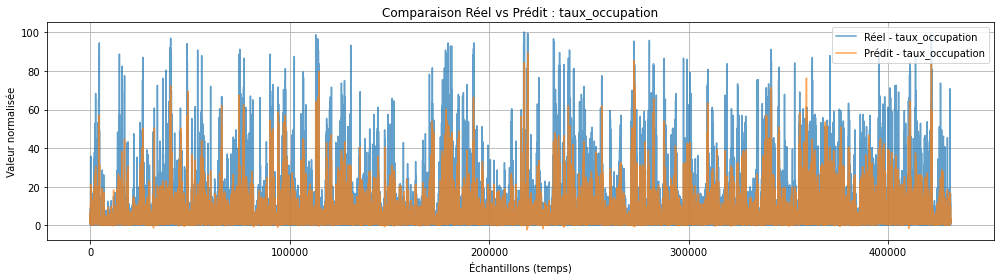

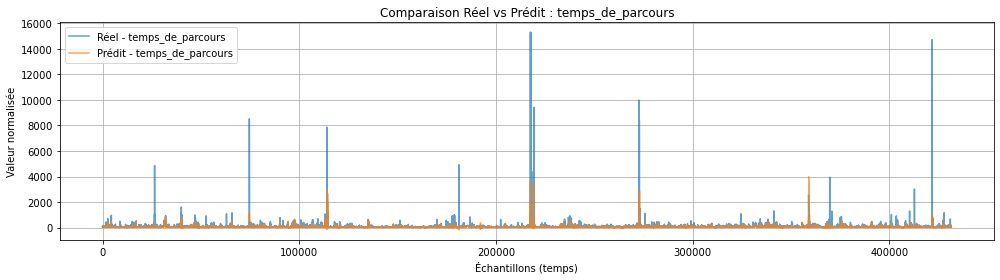

In [21]:

# --- Reconstruire les tableaux si nécessaire ---
# y_true, y_pred doivent déjà être définis après l'évaluation (voir code précédent)

# --- Variable 1 : taux_occupation ---
plt.figure(figsize=(14, 4))
plt.plot(y_true_rescaled[:, 0], label='Réel - taux_occupation', alpha=0.7)
plt.plot(y_pred_rescaled[:, 0], label='Prédit - taux_occupation', alpha=0.7)
plt.title("Comparaison Réel vs Prédit : taux_occupation")
plt.xlabel("Échantillons (temps)")
plt.ylabel("Valeur normalisée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Variable 2 : temps_de_parcours ---
plt.figure(figsize=(14, 4))
plt.plot(y_true_rescaled[:, 1], label='Réel - temps_de_parcours', alpha=0.7)
plt.plot(y_pred_rescaled[:, 1], label='Prédit - temps_de_parcours', alpha=0.7)
plt.title("Comparaison Réel vs Prédit : temps_de_parcours")
plt.xlabel("Échantillons (temps)")
plt.ylabel("Valeur normalisée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
link = '/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/src/taux_occupation_predictions.csv'
df_pred = pd.read_csv (link)

In [23]:
df_pred.head()

,heure_arrondie,nom_du_troncon,taux_occupation_reel,taux_occupation_pred
0,2025-03-08 00:00:00,3 Continents I,3.50,3.791160
1,2025-03-08 00:15:00,3 Continents I,3.30,3.525492
2,2025-03-08 00:30:00,3 Continents I,4.10,3.378155
3,2025-03-08 00:45:00,3 Continents I,2.50,3.614953
4,2025-03-08 01:00:00,3 Continents I,2.15,2.680743


In [24]:
print(df_pred['taux_occupation_reel'].min())
print(df_pred['taux_occupation_reel'].max())

0.2000001513506517
100.00000059053136


In [25]:
print(df_pred['taux_occupation_pred'].min())
print(df_pred['taux_occupation_pred'].max())

-2.301885721896212
89.34384985316974
